# State Street 500 proxy voting patterns

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Want to have your voice as a shareholder heard? Join us at <a href="https://matter-funds.com">Matter</a>.
</footer>


## Proxy voting

A large percentage of the equities market is managed passively (up to 40% according to a [report by Bank of America](https://www.reuters.com/article/us-stocks-etf-research-idUSKBN19Q18B)). As we've discussed in other places at Matter (/TODO: links), this raises concerns about the effectiveness of corporate governance in the modern world.

Passive index funds are incentivised to:
1. track the performance of their benchmark (e.g. S&P 500)
1. do it as cheaply as possible.

Those two incentives means there is little reason for passive funds to engage and disagree with management on any issue: engagement requires costly reseach, time and effort and it doesn't make the index fund track the benchmark any more closely.

Arguably, it is easier for passive index funds to follow management or third-party voting recommendations, with the result being a world where the balance of power is tipped excessively towards corporate managers.

To gain a better understanding of the phenomenon, we look at historical voting data from top passive index providers.

For the impacient reader, we see the following stylised facts:
<a id="section_0"></a>
1. A large percentage of management proposals are concerned with corporate compensation. By contrast, top issues for shareholders are board independence and transparency around corporate lobbying and political contributions. ([details](#section_top_issues))
1. Management largely recommends voting `Against` shareholder proposals and `For` management proposals ([details](#section_2))
1. Only around 6% of the voting proposals are sponsored by shareholders - that number has been increasing in recent years. ([details](#section_1))
1. State Street follows management recommendations an overwhelmingly large number of times - around 93% of the time. ([details](#section_3)) That number is even higher in recent times, mostly due to State Street increasingly siding with management on votes proposed by shareholders. ([details](#section_4))
1. State Street has been increasingly disagreeing with management voting recommendations when it comes to votes on corporate compensation. ([details](#section_5))

## The data

In the US, mutual funds are legally required to:
1. cast all their proxy votes
2. disclose their voting via a [form N-PX](https://www.sec.gov/edgar/searchedgar/n-px.htm).

An example of what the [raw N-PX data](https://www.sec.gov/Archives/edgar/data/1094885/000119312518263427/0001193125-18-263427.txt) looks like:
```
APPLE INC.

Ticker:       AAPL           Security ID:  037833100
Meeting Date: FEB 13, 2018   Meeting Type: Annual
Record Date:  DEC 15, 2017

#   Proposal                             Mgt Rec Vote Cast Sponsor
1a  Elect Director James Bell            For     For       Management
1b  Elect Director Tim Cook              For     For       Management
1c  Elect Director Al Gore               For     For       Management
1d  Elect Director Bob Iger              For     For       Management
1e  Elect Director Andrea Jung           For     For       Management
1f  Elect Director Art Levinson          For     For       Management
1g  Elect Director Ron Sugar             For     For       Management
1h  Elect Director Sue Wagner            For     For       Management
2   Ratify Ernst & Young LLP as Auditors For     For       Management
3   Advisory Vote to Ratify Named        For     For       Management
    Executive Officers' Compensation
4   Amend Non-Employee Director Omnibus  For     For       Management
    Stock Plan
5   Proxy Access Amendments              Against Against   Shareholder
6   Establish Human Rights Committee     Against Against   Shareholder
```

The above shows how [State Street Equity 500](https://money.usnews.com/funds/mutual-funds/large-blend/state-street-equity-500-index-fund/stfax) - a large S&P 500 tracking fund - voted in the Apple Annual General Meeting.
The data is quite rich - we can see:
1. The name of each proposal
1. How management recommends their shareholders vote
1. How State Street voted
1. Who is sponsoring the proposal.

### Parsed data
As part of our research work at Matter, we collect, clean and parse mutual fund voting data. You can see the codebase used to generate the State Street data [here](https://github.com/matter-funds/npx_forms).

Let's look at the parsed data for State Street Equity 500.
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show all code"></form>

In [36]:
from pathlib import Path
import pandas as pd
npx_parsed_path = Path("/home/bogdan/projects/proxymonitor/data/npx_forms_parsed")
npx_files = list(npx_parsed_path.glob("*.csv"))
ps = [pd.read_csv(f) for f in npx_files]
for df,file in zip(ps, npx_files):
    token = str(file).split('-')[1]
    df['VoteId'] = df['VoteId'].astype(str) + '_' + token
ps = pd.concat(ps, ignore_index=True)

In [37]:
ps['MeetDate'] = pd.to_datetime(ps['MeetDate'])
ps['RecDate'] = pd.to_datetime(ps['RecDate'])

In [38]:
#Drop badly parsed rows:
ps = ps[~ps["NumType"].isnull()]
ps = ps[~ps["Num"].isnull()]

adj_term = ps['MeetDate'].min() - pd.to_datetime('2014.01.01')
ps['ReportYear'] = (ps['MeetDate'] - adj_term).dt.year + 1

In [39]:
from IPython.display import display, HTML
display(HTML(ps.head().to_html(index=False)))

VoteId,Num,Proposal,MgtRec,VoteCast,Sponsor,Name,Ticker,secid,MeetDate,MeetType,RecDate,NumType,NumRoot,ReportYear
VoteId0_17,1a,Elect Director Sondra L. Barbour,For,For,Management,3M COMPANY,MMM,88579Y101,2017-05-09,Annual,2017-03-14,digit_first,1,2017
VoteId0_17,1b,"Elect Director Thomas ""Tony"" K. Brown",For,For,Management,3M COMPANY,MMM,88579Y101,2017-05-09,Annual,2017-03-14,digit_first,1,2017
VoteId0_17,1c,Elect Director Vance D. Coffman,For,For,Management,3M COMPANY,MMM,88579Y101,2017-05-09,Annual,2017-03-14,digit_first,1,2017
VoteId0_17,1d,Elect Director David B. Dillon,For,For,Management,3M COMPANY,MMM,88579Y101,2017-05-09,Annual,2017-03-14,digit_first,1,2017
VoteId0_17,1e,Elect Director Michael L. Eskew,For,For,Management,3M COMPANY,MMM,88579Y101,2017-05-09,Annual,2017-03-14,digit_first,1,2017


We get one row per proposal with some metadata added for convenience.

Let's now look at the coverage.

In [40]:
pt = ps.groupby(by=['ReportYear','MeetType'])['VoteId'].agg(lambda x:len(x.unique())).reset_index(name='Vote Count')
pt = pt.pivot_table(index='ReportYear', columns='MeetType', values='Vote Count', fill_value=0)
pt['Total'] = pt.sum(axis=1)
pt

MeetType,Annual,Court,Proxy Contest,Special,Total
ReportYear,,,,,
2015,485,1,4,32,522
2016,485,2,0,41,528
2017,493,0,3,22,518
2018,489,1,5,17,512


As expected, we have almost 500 annual meeetings each year (500 index members), and around 30 Special meetings each year. Special meetings are organised ad-hoc for important timely matters, such as merges, acquisitions and golden parachutes for corporate.

Our data goes back all the way to reporting year 2015 - earliest covered meeting took place on 2014.07.07.

## Whose vote is it anyway?

Whenever a vote is submitted, it is sponsored either by management or shareholders. Most of the time, votes are proposed by management, however, ocassionally, shareholders feel the need to raise votes on certain issues.

Let's look at the most common votes for both groups.

In [41]:
#collapse the more common proposals around electing new directors and auditors.
ps['Proposal_generic'] = ps['Proposal'].copy()
ps.loc[ps['Proposal_generic'].str.startswith("Elect Director "), 'Proposal_generic'] = 'Elect Director <Name>'
ps.loc[ps['Proposal_generic'].str.match('^Ratify .* as Auditors$', case=False), 'Proposal_generic'] = 'Ratify <Name> as Auditors'

<a id="section_top_issues"></a>
[<div style="float: right">Go to stylised facts</div>](#section_0)
Management top 10 most common votes are:

In [42]:
ps[ps['Sponsor']=='Management']['Proposal_generic'].value_counts().head(10).to_frame(name='Vote Count')

,Vote Count
Elect Director <Name>,19169
Advisory Vote to Ratify Named Executive Officers' Compensation,1899
Ratify <Name> as Auditors,1811
Advisory Vote on Say on Pay Frequency,487
Amend Omnibus Stock Plan,314
Approve Omnibus Stock Plan,145
Amend Executive Incentive Bonus Plan,96
Adjourn Meeting,96
Ratify Auditors,77
Advisory Vote on Golden Parachutes,68


For shareholders, top 10 most common votes are:

In [43]:
ps[ps['Sponsor']=='Shareholder']['Proposal_generic'].value_counts().head(10).to_frame(name='Vote Count')

,Vote Count
Require Independent Board Chairman,166
Report on Lobbying Payments and Policy,143
Provide Right to Act by Written Consent,100
Report on Political Contributions,83
Proxy Access,76
Adopt Proxy Access Right,65
Reduce Ownership Threshold for Shareholders to Call Special Meeting,58
Elect Director <Name>,34
Pro-rata Vesting of Equity Awards,33
Amend Proxy Access Right,33


Interestingly, corporate compensation is high on the management agenda (#2 and #4 in management top 10). For shareholders, the most important issues are having an independent chairman and increased transparency around coporate lobbying and political contributions.

<a id="section_2"></a>
[<div style="float: right">Go to stylised facts</div>](#section_0)
We also expect to see management generally opposing shareholder votes. Sure enough, the data agrees:

In [44]:
pt = ps.groupby(by=['MgtRec','Sponsor']).size().reset_index(name='Vote Count')
pt['Percentage'] = pt.groupby(by=['Sponsor'])['Vote Count'].transform(lambda x:x/sum(x))
pt = pt.pivot_table(index='MgtRec',columns='Sponsor',values=['Vote Count','Percentage'],fill_value=0)
pt

Percentage             Vote Count            
Sponsor      Management Shareholder Management Shareholder
MgtRec                                                    
Abstain        0.000000    0.000569          0           1
Against        0.000234    0.927149          6        1629
Against None   0.000000    0.000569          0           1
For            0.979349    0.056915      25135         100
None           0.001714    0.014229         44          25
One Year       0.017923    0.000000        460           0
Three Years    0.000779    0.000000         20           0
Withhold       0.000000    0.000569          0           1

Management recommends voting Against shareholder proposals a whopping 93% of the time.

<a id="section_1"></a>
[<div style="float: right">Go to stylised facts</div>](#section_0)
Given this tension between shareholder and management proposals, how often do shareholders sponsor votes? Let's look at a breakdown by years:

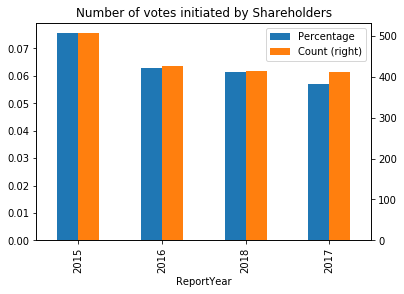

Raw data:


Sponsor,ReportYear,Count,Percentage
Shareholder,2015,506,0.075522
Shareholder,2016,426,0.062915
Shareholder,2018,414,0.061470
Shareholder,2017,411,0.056957


In [45]:
import matplotlib.pyplot as plt

pt = ps.groupby(by=['Sponsor','ReportYear']).size().reset_index(name='Count').sort_values('Count', ascending=False)
pt['Percentage'] = pt.groupby(by=['ReportYear'])['Count'].transform(lambda x:x/sum(x))
pt[pt['Sponsor']=='Shareholder'].plot(x='ReportYear', y=['Percentage','Count'], secondary_y=['Count'],
                     kind='bar',
                     title='Number of votes initiated by Shareholders')
plt.show()
print('Raw data:')
display(HTML(pt[pt['Sponsor']=='Shareholder'].to_html(index=False)))

So only 6% of the votes are proposed by shareholders, with that number decreasing noticeably in recent years.

## A matter of form?

<a id="section_3"></a>
[<div style="float: right">Go to stylised facts</div>](#section_0)
The N-PX reports also helpfully include both the vote cast by the fund as well as the management recommendation. So let's take a look at how often State Street voted in line with management's wishes.

In [46]:
ps['Agree'] = ps['MgtRec']==ps['VoteCast']

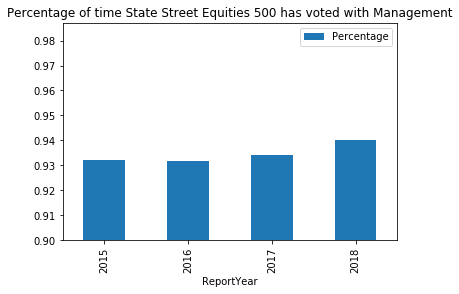

Raw data:


Agree,ReportYear,Count,Percentage
True,2015,6245,0.932090
True,2016,6308,0.931620
True,2017,6741,0.934174
True,2018,6331,0.940015


In [47]:
pt = ps.groupby(by=['Agree','MgtRec','VoteCast','ReportYear']).size().reset_index(name='Count').sort_values('Count', ascending=False)
pt = pt.groupby(by=['Agree','ReportYear']).agg({'Count':sum}).reset_index()
pt['Percentage'] = pt.groupby(by=['ReportYear'])['Count'].transform(lambda x:x/sum(x))
pt[pt['Agree']].plot(x='ReportYear', y=['Percentage'],
                     ylim=0.9, kind='bar',
                     title='Percentage of time State Street Equities 500 has voted with Management')
plt.show()
print('Raw data:')
display(HTML(pt[pt['Agree']].to_html(index=False)));

Two interesting points to note here:

1. The absolute level of agreement is around 93%. This means that funds disagree with management on only 1 vote out of 200. While this may seem like a large value, it is difficult to know what this means. Is management following State Street's indications? Or is State Street passively following management recommendations? Who is driving this particular bus?
1. The agreement ratio has been trending upwards in recent years, so this fund-management dynamic has been increasing in strength.

<a id="section_4"></a>
[<div style="float: right">Go to stylised facts</div>](#section_0)
To further drill into the apparent agreement between management and fund voting, let's look at a breakdown by vote sponsor:

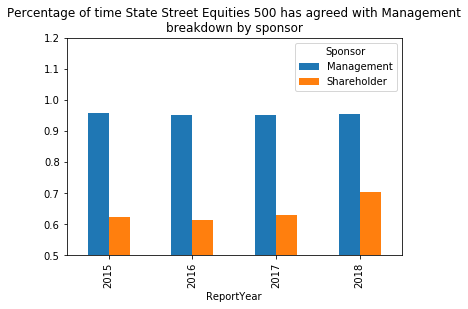

Raw data:


Sponsor,Management,Shareholder
ReportYear,,
2015,0.957217,0.624506
2016,0.952876,0.615023
2017,0.952535,0.630170
2018,0.955387,0.705314


In [48]:
pt = ps.groupby(by=['Agree','MgtRec','VoteCast','ReportYear','Sponsor']).size().reset_index(name='Count').sort_values('Count', ascending=False)
pt = pt.groupby(by=['Agree','ReportYear','Sponsor']).agg({'Count':sum}).reset_index()
pt['Percentage'] = pt.groupby(by=['ReportYear','Sponsor'])['Count'].transform(lambda x:x/sum(x))
pt = pt[pt['Agree']].pivot(index='ReportYear',columns='Sponsor',values='Percentage')
pt.reset_index().plot(x='ReportYear', y=['Management', 'Shareholder'],
                      ylim=(0.5,1.2), kind='bar',
                      title='Percentage of time State Street Equities 500 has agreed with Management\nbreakdown by sponsor');
plt.show()
print('Raw data:')
display(HTML(pt.to_html()))

So agreement between fund and management has seen a marked increase for shareholder-sponsored votes. Moreover, this is happening in the context of there beeing fewer and fewer shareholder-backed votes, as we've seen above.

So not only are shareholders proposing fewer votes, they are also seeing less success in terms of convincing State Street to vote with them.

## Show me the money

How contentious are votes related to corporate compensation?

First, how often are such votes held?

In [49]:
ps['Comp related'] = ps['Proposal'].str.contains('compensation', case=False)

In [50]:
pt = ps.groupby(by=['Comp related']).size().reset_index(name='Vote Count')
pt['Percentage'] = pt['Vote Count']/pt['Vote Count'].sum()
display(HTML(pt.to_html(index=False)))

Comp related,Vote Count,Percentage
False,25393,0.926008
True,2029,0.073992


Around 7% of the proposals are related to compensation somehow. This is quite a large percentage - in fact it is the 2nd most common type of vote after director elections, as can be seen below.

In [51]:
ps['Proposal_generic'].value_counts().to_frame().head(5)

,Proposal_generic
Elect Director <Name>,19203
Advisory Vote to Ratify Named Executive Officers' Compensation,1899
Ratify <Name> as Auditors,1811
Advisory Vote on Say on Pay Frequency,487
Amend Omnibus Stock Plan,314


<a id="section_5"></a>
[<div style="float: right">Go to stylised facts</div>](#section_0)
So how often has State Street disagreed with management on compensation votes?

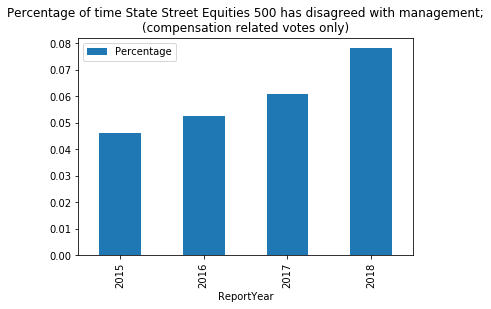

Raw data:


Agree,ReportYear,Vote Count,Percentage
False,2015,23,0.046000
False,2016,26,0.052738
False,2017,32,0.061069
False,2018,40,0.078125


In [52]:
pt = ps[ps['Comp related']]
pt = pt.groupby(by=['Agree','ReportYear']).size().reset_index(name='Vote Count')
pt['Percentage'] = pt.groupby(by=['ReportYear'])['Vote Count'].transform(lambda x:x/sum(x))
pt = pt[~pt['Agree']]
pt.reset_index().plot(x='ReportYear', y='Percentage',
                     kind='bar',
                     title='Percentage of time State Street Equities 500 has disagreed with management;\n(compensation related votes only)')
plt.show()
print('Raw data:')
display(HTML(pt.to_html(index=False)))

Interestingly, there has been a marked increase in disagreement between State Street and management when it comes to voting on compensation. This comes as no surprise, as corporate compensation has been a topic of dispute in the US in recent years, especially given the increasing levels of economic inequality.

## Conclusion

The data paints a picture of a world where:
1. Large passive mutual funds overwhelmingly vote the same way that management recommends
1. Corporate management holds disproportionately large votes on issues such as compensation
1. There have been fewer and fewer shareholder-backed votes - and the votes that are put forward by shareholders are seeing lower and lower levels of support from the large passive mutual funds

Not all news are bad - State Street has been increasingly pushing back on executive compensation votes, although only around 7% of the time.

If you are interested in seeing more research like this, follow us at [Matter](https://matter-funds.com)